# Aggregate proteomic data across studies

For best results, first run the [IdentifierUpdates_Proteomics](./IdentifierUpdates_Proteomics.ipynb) notebook first to remove old/obsolete accessions and map to current UniProt database. 
## Load protein table

Run the  notebook first to create the protein table.
Note: Requires internet connection to download information from the UniProt.

## Setup
### Import packages

In [1]:
from warnings import warn
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    EXTERNAL_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    RESULTS_PATH,
    check_version,
    check_database_version_online,
    show_versions,
)


from rbc_gem_utils.database.uniprot import (
    UNIPROT_VERSION_EXPECTED,
    get_version_UniProt,
    query_UniProt,
)

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2024_01
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2024_01](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Jan 24 2024**.

In [2]:
if not check_database_version_online("UniProt"):
    warn(
        "Online version of database has been updated since the last time notebook was used."
    )

version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"

Current and expected versions match.


## Load aggregated proteomic data, updated IDs

In [3]:
excel_filepath_processed = (
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomics_aggregated.xlsx"
)

### Load table of contents

In [4]:
df_contents = pd.read_excel(
    excel_filepath_processed, sheet_name="Table of Contents", dtype=str
).fillna("")
df_contents

,PubMed/Sheet Name,ID type,Year,Publication,Notes
0,12362340,UniProt,2002,"Low TY, Seow TK, Chung MC. Separation of human...",84 UniProt --> 79 UniProt 2024_01
1,14963112,UniProt,2004,"Kakhniashvili DG, Bulla LA Jr, Goodman SR. The...",183 GI;110 Obsolete;92 UniProt --> 92 UniProt...
2,16861337,UniProt,2006,"Pasini EM, Kirkegaard M, Mortensen P, Lutz HU,...",590 IPI;146 Obsolete;439 UniProt --> 442 UniP...
3,18399644,UniProt,2008,"Simó C, Bachi A, Cattaneo A, Guerrier L, Forti...",153 IPI;18 Obsolete;135 UniProt --> 136 UniPr...
4,18494517,UniProt,2008,"Ringrose JH, van Solinge WW, Mohammed S, O'Fla...",699 IPI;299 Obsolete;400 UniProt --> 400 UniP...
5,18614565,UniProt,2008,"Roux-Dalvai F, Gonzalez de Peredo A, Simó C, G...",1577 IPI;256 Obsolete;1318 UniProt --> 1321 U...
6,19778645,UniProt,2009,"van Gestel RA, van Solinge WW, van der Toorn H...",561 GI;137 Obsolete;473 UniProt --> 473 UniPr...
7,22157974,UniProt,2011,"D'Amici GM, Rinalducci S, Zolla L. Depletion o...",134 GI;178 Obsolete;62 UniProt --> 62 UniProt...
8,22954596,UniProt,2012,"Pesciotta EN, Sriswasdi S, Tang HY, Mason PJ, ...",831 UniProt --> 765 UniProt 2024_01
9,23781972,UniProt,2013,"Pallotta V, D'Alessandro A, Rinalducci S, Zoll...",140 GI;28 Obsolete;153 UniProt --> 153 UniPro...


### Aggregate proteins into table

In [5]:
all_sheet_dfs = {"Table of Contents": df_contents}

index_name = "Uniprot"
df_proteins_aggregated = pd.DataFrame([], columns=[index_name])
for _, (sheet_name, id_type) in df_contents[
    ["PubMed/Sheet Name", "ID type"]
].iterrows():
    if id_type != "UniProt":
        warn("Can only utilize UniProt IDs for final aggregation")
        continue
    df = pd.read_excel(excel_filepath_processed, sheet_name=sheet_name, usecols=[0])
    df.columns = [sheet_name]
    df[index_name] = df[sheet_name]
    all_sheet_dfs[sheet_name] = df.copy()
    df_proteins_aggregated = df_proteins_aggregated.merge(
        df, left_on=index_name, right_on=index_name, how="outer"
    )
df_proteins_aggregated = (
    df_proteins_aggregated.drop_duplicates().set_index(index_name).notna()
)
df_proteins_aggregated.columns.name = "pubmed"
# MIRIAM compliant
df_proteins_aggregated = df_proteins_aggregated.rename(
    {col: f"pubmed:{col}" for col in df_proteins_aggregated.columns}, axis=1
)
df_unreviewed_proteins = df_proteins_aggregated.copy()
df_unreviewed_proteins

pubmed,pubmed:12362340,pubmed:14963112,pubmed:16861337,pubmed:18399644,pubmed:18494517,pubmed:18614565,pubmed:19778645,pubmed:22157974,pubmed:22954596,pubmed:23781972,...,pubmed:28689405,pubmed:30327373,pubmed:31552303,pubmed:33103907,pubmed:33341364,pubmed:33806028,pubmed:35858567,pubmed:36346805,pubmed:37760001,pubmed:37942280
Uniprot,,,,,,,,,,,,,,,,,,,,,
A0A024QZ42,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024QZ64,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R0L6,False,False,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
A0A024R1A3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
A0A024R1I3,False,False,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X6RA14,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
X6RAJ1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
X6RCK5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Query UniProt, keep reviewed proteins

In [6]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(
        [
            "reviewed",
            "accession",
            "gene_primary",
        ]
    ),
}

df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(df_unreviewed_proteins.index),
    query_parameters=query_parameters,
    from_db="UniProtKB",
    to_db="UniProtKB",
    return_failed=True,
)

df_results = df_results[df_results["Reviewed"] == "reviewed"].drop_duplicates()
df_results

Fetched: 500 / 4369
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Fetched: 1000 / 4369
Fetched: 1500 / 4369
Fetched: 2000 / 4369
Fetched: 2500 / 4369
Fetched: 3000 / 4369
Fetched: 3500 / 4369
Fetched: 4000 / 4369


Number of failed query IDs : 1499


Fetched: 4369 / 4369


,From,Reviewed,Entry,Gene Names (primary)
0,A0A075B6H9,reviewed,A0A075B6H9,IGLV4-69
1,A0A075B6K4,reviewed,A0A075B6K4,IGLV3-10
2,A0A075B6S2,reviewed,A0A075B6S2,IGKV2D-29
3,A0A075B6S5,reviewed,A0A075B6S5,IGKV1-27
4,A0A087WSY6,reviewed,A0A087WSY6,IGKV3D-15
...,...,...,...,...
4364,Q9Y6V0,reviewed,Q9Y6V0,PCLO
4365,Q9Y6W5,reviewed,Q9Y6W5,WASF2
4366,Q9Y6X4,reviewed,Q9Y6X4,FAM169A
4367,Q9Y6X8,reviewed,Q9Y6X8,ZHX2


In [7]:
df_reviewed_proteins = df_unreviewed_proteins.loc[df_results["Entry"].values]
df_reviewed_proteins = df_reviewed_proteins.astype(int)
df_reviewed_proteins = df_reviewed_proteins.loc[
    df_reviewed_proteins.sum(axis=1).sort_values(ascending=False).index.values
]
df_reviewed_proteins

pubmed,pubmed:12362340,pubmed:14963112,pubmed:16861337,pubmed:18399644,pubmed:18494517,pubmed:18614565,pubmed:19778645,pubmed:22157974,pubmed:22954596,pubmed:23781972,...,pubmed:28689405,pubmed:30327373,pubmed:31552303,pubmed:33103907,pubmed:33341364,pubmed:33806028,pubmed:35858567,pubmed:36346805,pubmed:37760001,pubmed:37942280
Uniprot,,,,,,,,,,,,,,,,,,,,,
P04406,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,1,1,1,1
P04040,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,1,1,1,1
P11142,1,1,1,1,1,1,0,0,1,1,...,1,1,0,1,1,1,1,1,1,1
P02549,1,1,1,1,0,1,1,0,1,0,...,1,1,0,1,1,1,1,1,1,1
P05089,1,1,1,0,0,1,1,0,1,0,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q15751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Q15738,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Q15717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Export protein table

In [8]:
df_reviewed_proteins.to_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv", sep="\t"
)

## Visualize Protein Table

In [9]:
# Turned into an xlsx where keys are sheet names and values are DataFrames representing the sheet
all_figure_data = {}
imagetype = "png"
transparent = True

### Create proteomic evidence table for figure
#### Sorted by publication year (original)

In [10]:
df_proteins = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
).astype(int)
df_proteins.columns.name = "pubmed"

# Order by umber of times a single  protein was detected across studies
protein_ids_ordered = df_proteins.sum(axis=1).sort_values(ascending=False).index.values
df_proteins = df_proteins.loc[protein_ids_ordered, :]
# Transport for figure
df_proteins = df_proteins.T
df_proteins

Uniprot,P04406,P04040,P11142,P05089,P00915,P27105,Q00013,Q99832,P02549,P25786,...,P32929,P30405,P30260,P30084,P29590,P29466,P29353,P28799,P30273,Q13247
pubmed,,,,,,,,,,,,,,,,,,,,,
pubmed:12362340,1,1,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:14963112,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:16861337,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18399644,1,1,1,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18494517,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,1,0,0,0
pubmed:19778645,1,1,0,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:22157974,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:22954596,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Reordered

In [11]:
# Order by number of proteins detected in a single study
df_proteins_reordered = df_proteins.T.copy()
pubmed_ids_ordered = (
    df_proteins_reordered.sum(axis=0).sort_values(ascending=False).index.values
)
df_proteins_reordered = df_proteins_reordered.loc[:, pubmed_ids_ordered]
df_proteins_reordered = df_proteins_reordered.T
df_proteins_reordered

Uniprot,P04406,P04040,P11142,P05089,P00915,P27105,Q00013,Q99832,P02549,P25786,...,P32929,P30405,P30260,P30084,P29590,P29466,P29353,P28799,P30273,Q13247
pubmed,,,,,,,,,,,,,,,,,,,,,
pubmed:28689405,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:30327373,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
pubmed:28263177,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,0,0,0,0
pubmed:37942280,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,1,1
pubmed:35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:33806028,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,1,0,0,0
pubmed:24555563,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:27006477,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


### Visualization

In [12]:
df_figure_data = df_proteins.copy()
df_figure_data = df_proteins_reordered.copy()
min_count = 0
max_count = 20
fontsize = 12

edgecolor = "black"
edgewidth = 0.5
bar_size = 0.75
as_percentages = True
cmin, cmax = (0.05, 1)

cmap = mpl.colormaps.get_cmap("terrain_r")
no_evidence_color = mpl.colors.to_rgba_array("xkcd:white")

In [13]:
all_figure_data["ProteomicEvidenceAll"] = df_figure_data.copy()


df_value_counts = df_figure_data.sum(axis=0).value_counts().sort_index()
value_counts = df_value_counts[df_value_counts.index <= max_count].to_dict()
value_counts[max(value_counts.keys())] += df_value_counts[
    df_value_counts.index > max_count
].sum()
value_counts = {int(k): v for k, v in value_counts.items()}
df_value_counts = pd.Series(value_counts, name="Total")
id_fix_dict = {max_count: f"$\geq${str(max_count)}"}
if min_count:
    value_counts = df_value_counts[df_value_counts.index >= min_count].to_dict()
    value_counts[min(value_counts.keys())] += df_value_counts[
        df_value_counts.index < min_count
    ].sum()
    value_counts = {int(k): v for k, v in value_counts.items()}
    id_fix_dict[min_count] = f"{str(min_count)}$\geq$"

value_counts = {id_fix_dict.get(k, k): v for k, v in value_counts.items()}


df_value_counts = pd.DataFrame.from_dict(
    value_counts, orient="index", columns=["Total"]
)
df_value_counts.index.name = "Proteomic evidence (#studies)"
# Add colormap to table
cmap_dict = dict(
    zip(
        df_value_counts.index, cmap(np.linspace(cmin, cmax, len(df_value_counts.index)))
    )
)

df_value_counts_colors = df_value_counts.copy()
df_value_counts_colors["Colors"] = cmap_dict
df_value_counts_colors = df_value_counts_colors.reindex(
    index=df_value_counts_colors.index[::-1]
)
df_value_counts_colors.index = df_value_counts_colors.index.astype(str)
df_value_counts_colors

,Total,Colors
Proteomic evidence (#studies),,
$\geq$20,51,"[0.2, 0.2, 0.6, 1.0]"
19,47,"[0.13725490196078433, 0.3254901960784314, 0.72..."
18,52,"[0.06928104575163399, 0.46143790849673205, 0.8..."
17,68,"[0.0013071895424836603, 0.5973856209150327, 0...."
16,74,"[0.0, 0.7, 0.7, 1.0]"
15,79,"[0.0, 0.7941176470588236, 0.4176470588235294, ..."
14,88,"[0.19215686274509802, 0.8384313725490197, 0.43..."
13,78,"[0.39607843137254906, 0.8792156862745099, 0.47..."
12,101,"[0.6, 0.92, 0.52, 1.0]"


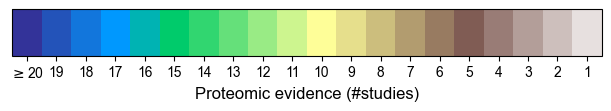

In [14]:
orientation = "horizontal"
figsize = (1 if orientation == "vertical" else 6, 6 if orientation == "vertical" else 1)
fig_colorbar, cbar_ax = plt.subplots(figsize=figsize, layout="constrained")

cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", list(cmap_dict.values()), len(cmap_dict)
)
xticks = list(np.linspace(0, len(cmap_dict) - 1, len(cmap_dict)) + 0.5)
if orientation == "vertical":
    cmap_segmented = cmap_segmented.reversed("legend")
    xticks.reverse()

norm = mpl.colors.BoundaryNorm(
    np.linspace(0, len(cmap_dict), len(cmap_dict) + 1), cmap_segmented.N
)
colorbar = fig_colorbar.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap_segmented),
    cax=cbar_ax,
    orientation=orientation,
    label=df_value_counts_colors.index.name,
)
colorbar.set_ticks(
    xticks, minor=False, labels=df_value_counts_colors.index, fontsize=fontsize - 2
)
colorbar.set_ticks([], minor=True)
cbar_ax.set_xlabel(df_value_counts_colors.index.name, fontdict={"size": fontsize})
fig_colorbar;

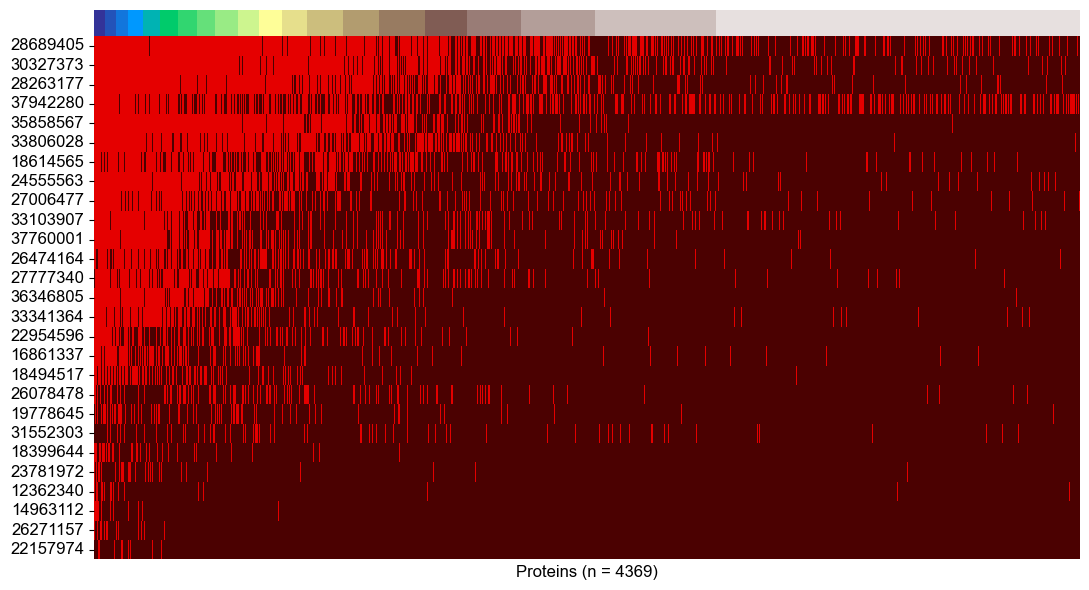

In [15]:
fig = mpl.figure.Figure(figsize=(11, 6))
gs = mpl.gridspec.GridSpec(2, 1, hspace=0, height_ratios=[0.05, 1])

df_proteomic_cmap = df_figure_data.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x < max_count else max_count)
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x > min_count else min_count)

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", [cmap_dict[c] for c in df_value_counts_colors.index[::-1]], len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    np.array([df_proteomic_cmap.values]),
    ax=fig.add_subplot(gs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)


ax_heatmap = sns.heatmap(
    df_figure_data.rename(
        {row: row.lstrip("pubmed:") for row in df_figure_data.index}, axis=0
    ),
    ax=fig.add_subplot(gs[1]),
    cbar=False,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(
    f"Proteins (n = {len(df_figure_data.columns)})", fontsize=fontsize
)
ax_heatmap.set_ylabel(None)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis="y", labelsize=fontsize)

fig.tight_layout()
fig.savefig(
    f"{ROOT_PATH}{RESULTS_PATH}/proteomics/AllProteomicEvidence_PanelA.{imagetype}",
    transparent=transparent,
    format=imagetype,
)
fig

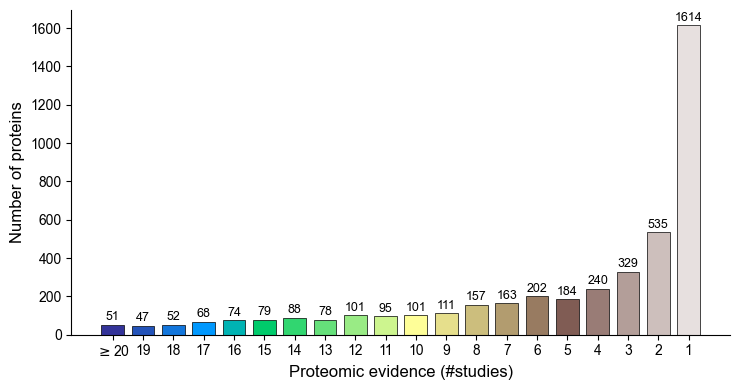

In [16]:
fig, ax_barchart = plt.subplots(1, 1, figsize=(7.5, 4))
sns.despine(ax=ax_barchart)

df_total_proteins = df_value_counts_colors["Total"]
rects = ax_barchart.bar(
    df_total_proteins.index,
    df_total_proteins.values,
    bar_size,
    color=df_value_counts_colors["Colors"].values,
    edgecolor=edgecolor,
    linewidth=edgewidth,
)
ax_barchart.bar_label(
    rects, labels=df_total_proteins.values, padding=1, fontsize=fontsize - 3
)
ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
all_figure_data["ProteomicEvidenceSummary"] = df_total_proteins.copy()

fig.tight_layout()
fig.savefig(
    f"{ROOT_PATH}{RESULTS_PATH}/proteomics/AllProteomicEvidence_PanelB.{imagetype}",
    transparent=transparent,
    format=imagetype,
)
fig;

### Aggregate Panels for visualization

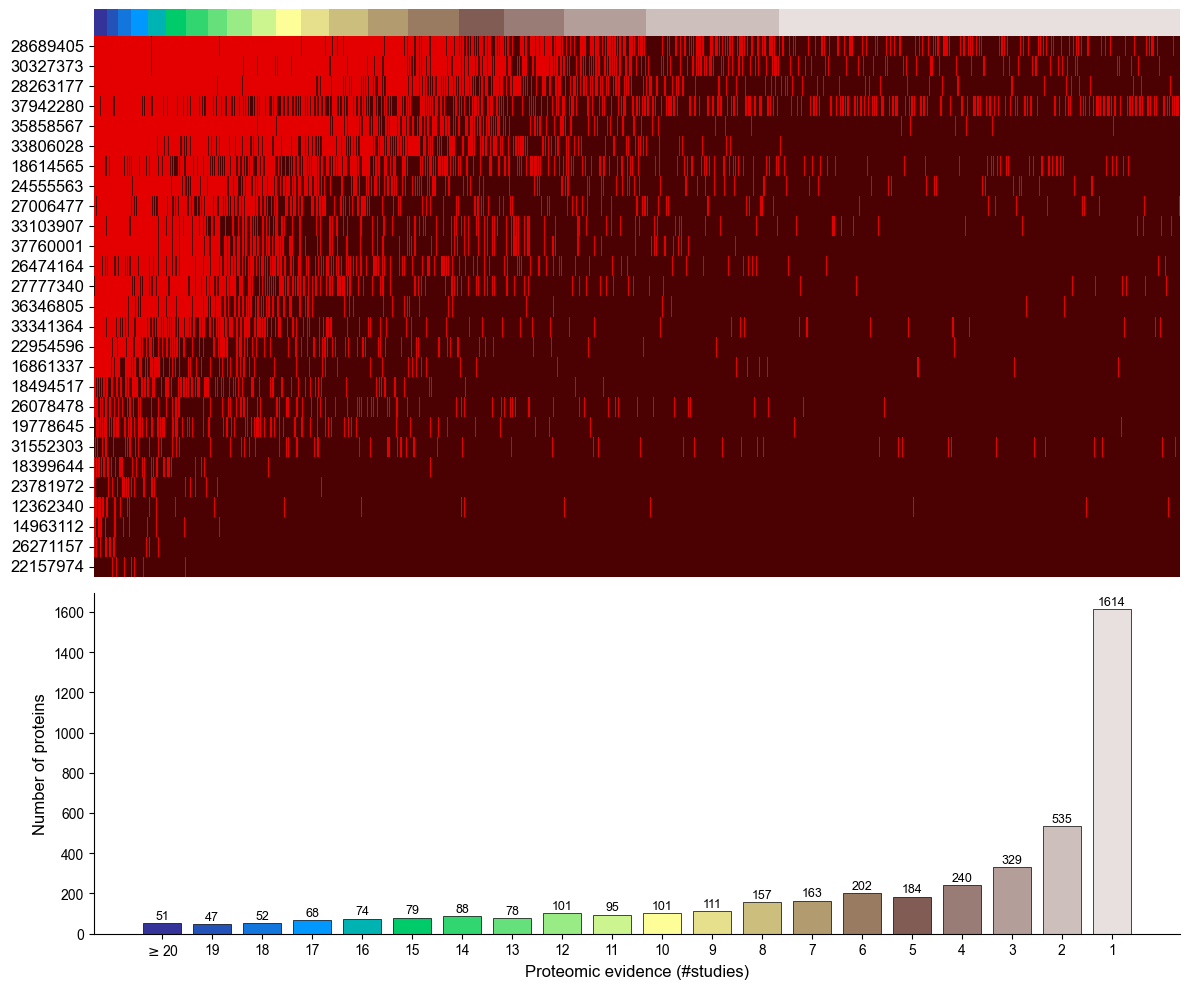

In [17]:
fig = mpl.figure.Figure(figsize=(12, 10))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1, 0.6])
sgs = mpl.gridspec.GridSpecFromSubplotSpec(
    2, 1, hspace=0, height_ratios=[0.05, 1], subplot_spec=gs[0]
)

has_additional_evidence_color, no_additional_evidence_color = (
    mpl.colors.to_rgba_array("xkcd:dark grey"),
    np.array([x / 2 + 0.5 for x in mpl.colors.to_rgba_array("xkcd:light grey")]),
)

df_proteomic_cmap = df_figure_data.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x < max_count else max_count)
df_proteomic_cmap = np.array([df_proteomic_cmap.values])

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", [cmap_dict[c] for c in df_value_counts_colors.index[::-1]], len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    df_proteomic_cmap,
    ax=fig.add_subplot(sgs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)

# Heatmap
ax_heatmap = sns.heatmap(
    df_figure_data.rename(
        {row: row.lstrip("pubmed:") for row in df_figure_data.index}, axis=0
    ),
    ax=fig.add_subplot(sgs[1]),
    cbar=False,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(None)
ax_heatmap.set_ylabel(None)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis="y", labelsize=fontsize)
# ax_heatmap.set_xlabel(f"Model proteins (n = {len(df_model.columns)})", fontsize=fontsize+2)


# Barchart
ax_barchart = fig.add_subplot(gs[1])
sns.despine(ax=ax_barchart)

df_total_proteins = df_value_counts_colors["Total"]
rects = ax_barchart.bar(
    df_total_proteins.index,
    df_total_proteins.values,
    bar_size,
    color=df_value_counts_colors["Colors"].values,
    edgecolor=edgecolor,
    linewidth=edgewidth,
)
ax_barchart.bar_label(
    rects, labels=df_total_proteins.values, padding=1, fontsize=fontsize - 3
)
ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
fig.tight_layout()
fig.savefig(
    f"{ROOT_PATH}{RESULTS_PATH}/proteomics/AllProteomicEvidence_PanelAB.{imagetype}",
    transparent=transparent,
    format=imagetype,
)
fig

## Export Figures and Data

In [18]:
print(all_figure_data.keys())
with pd.ExcelWriter(
    f"{ROOT_PATH}{RESULTS_PATH}/proteomics/AllProteomicsData.xlsx"
) as writer:
    for sheet_name, df in all_figure_data.items():
        df = df.T.reset_index(drop=False)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

dict_keys(['ProteomicEvidenceAll', 'ProteomicEvidenceSummary'])


#### Look up specific protein
Paste a list of UniProt Identifiers into the string to look up how many times those proteins were detected



In [19]:
plist = """
P53985
Q8TF71
O15427
O60669
""".strip().split(
    "\n"
)
df = df_figure_data.T
df = df[df.index.isin(plist)]
for x in df.index:
    print(x)
# df[df > 10]
df.sum(axis=1)

P53985
O60669
Q8TF71
O15427


Uniprot
P53985    13
O60669     2
Q8TF71     2
O15427     1
dtype: int64

#### Example
Example given is for removed proteins.

In [20]:
plist = """
Q08828
O60266
Q8NFM4
O95622
O43306
P51828
P40145
O60503
O15120
Q9NUQ2
O94788
P17707
Q06278
Q9UN42
Q92903
Q9Y6K0
P35790
Q9Y259
Q8WUD6
Q05315
Q86VU5
P36551
P23786
Q9Y2S2
Q9Y6T7
P52429
P49619
Q86XP1
O75912
P52824
Q13574
P22413
Q9HBU6
Q9NVF9
P09467
O00757
P22830
P32189
Q14410
Q14409
Q9HCL2
Q86UL3
P33402
O75343
P25092
Q02846
P51841
P52789
Q2TB90
P09601
P30519
P20839
P23677
P27987
Q96DU7
Q9UHV8
Q00266
O95544
O75414
Q9Y5B8
Q9NWW6
P16066
P20594
O14841
Q9Y233
Q9HCR9
Q01064
Q14123
P27815
Q07343
Q08493
Q13946
Q9NP56
O60658
O95263
P16118
O60825
Q16875
Q16877
Q9UBF8
Q9Y2I7
O14986
P14555
O60733
O14494
O43688
O14495
P50336
P51606
Q9H310
O15244
O75751
Q14542
Q9BYW1
Q6PXP3
Q9NY64
Q9H2H9
Q96QD8
Q969I6
P13866
P53794
Q92911
Q9GZV3
Q9UN76
P52569
Q8WY07
Q9Y6L6
Q9NPD5
P17735
O60701
P22309
P22310
Q8TF68
""".strip().split(
    "\n"
)
df = df_figure_data.T
df = df[df.index.isin(plist)]
for x in df.index:
    print(x)
# df[df > 10]
df.sum(axis=1)

P36551
P22830
Q05315
O14494
P09601
Q07343
Q14123
Q96QD8
P52569
P23786


Uniprot
P36551    6
P22830    4
Q05315    4
O14494    1
P09601    1
Q07343    1
Q14123    1
Q96QD8    1
P52569    1
P23786    1
dtype: int64